<a href="https://colab.research.google.com/github/sokrypton/laxy/blob/main/examples/kmeans_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# code inspiration credit:
# https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/cluster/_kmeans.py
# https://github.com/shpotes/clustering/blob/master/src/_kmeans.py

In [ ]:
import jax
import jax.numpy as jnp
from math import log
import numpy as np
import matplotlib.pyplot as plt

kmeans

In [ ]:
def _dist(a,b):
  sm = a @ b.T
  a_norm = jnp.square(a).sum(-1)
  b_norm = jnp.square(b).sum(-1)
  return jnp.abs(a_norm[:,None] + b_norm[None,:] - 2 * sm)

def _kmeans_plus_plus(key, X, X_weight, n_clusters):
  '''kmeans++ implemented in jax, for initialization'''
  n_samples, n_features = X.shape
  n_candidates = 2 + int(log(n_clusters))
  
  def loop(m,c):
    n,k = c
    inf_mask = jnp.inf * (jnp.arange(n_clusters) > n)
    p = (inf_mask + _dist(X,m)).min(-1)

    # sample candidates
    candidates = jax.random.choice(k, jnp.arange(n_samples),
                                   shape=(n_candidates,),
                                   p=p/p.sum(), replace=False)
    
    # pick sample that decreases inertia the most
    dist = jnp.minimum(p[:,None],_dist(X,X[candidates]))
    i = candidates[(X_weight[:,None] * dist).sum(0).argmin()]
    return m.at[n].set(X[i]), None

  i = jax.random.choice(key,jnp.arange(n_samples))
  init_means = jnp.zeros((n_clusters,n_features)).at[0].set(X[i])
  carry = (jnp.arange(1,n_clusters), jax.random.split(key, n_clusters-1))
  return jax.lax.scan(loop, init_means, carry)[0]

In [ ]:
def kmeans(X, X_weight, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, seed=0):
  '''kmeans implemented in jax'''
  def _E(means):
    # get labels
    return jax.nn.one_hot(_dist(X,means).argmin(-1), n_clusters)

  def _M(labels):
    # get means
    labels = labels * X_weight[:,None]
    labels /= labels.sum(0) + 1e-8
    return labels.T @ X
  
  def _inertia(means):
    # compute score: sum(min(dist(X,means)))
    sco = _dist(X,means).min(-1)
    return (X_weight * sco).sum()

  def single_run(key):
    # initialize
    init_means = _kmeans_plus_plus(key, X, X_weight, n_clusters)

    # run EM
    if tol == 0:
      means = jax.lax.scan(lambda mu,_:(_M(_E(mu)),None), init_means,
                           None, length=max_iter)[0]
    else:
      def EM(x):
        old_mu, old_sco, _, n = x
        new_mu = _M(_E(old_mu))
        new_sco = _inertia(new_mu)
        return new_mu, new_sco, old_sco, n+1
      def check(x):
        _, new_sco, old_sco, n = x
        return ((old_sco-new_sco) > tol) & (n < max_iter)
      init = EM((init_means,jnp.inf,None,0))
      means = jax.lax.while_loop(check, EM, init)[0]

    return {"means":means,
            "labels":_E(means),
            "inertia":_inertia(means)}

  # mulitple runs
  key = jax.random.PRNGKey(seed)
  if n_init > 0:
    out = jax.vmap(single_run)(jax.random.split(key,n_init))
    i = out["inertia"].argmin()
    out = {k:v[i] for k,v in out.items()}
  else:
    out = single_run(key)

  cat = (out["labels"] * X_weight[:,None]).sum(0) / X_weight.sum()
  return {**out, "cat":cat}

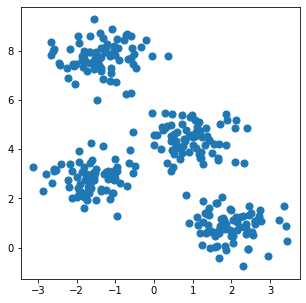

In [ ]:
from sklearn.datasets import make_blobs
plt.figure(figsize=(5,5))
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

In [ ]:
# jit compile kmeans
kmeans_jit = jax.jit(kmeans,static_argnums=(2,3,4,5,6))

In [ ]:
%%time
# first time is "slow" since it needs to compile
kms = kmeans_jit(jnp.array(X), jnp.ones(X.shape[0]), 4)
print(kms["inertia"])

212.00592
CPU times: user 2.11 s, sys: 475 ms, total: 2.58 s
Wall time: 2.49 s


In [ ]:
%%time
kms = kmeans_jit(jnp.array(X), jnp.ones(X.shape[0]), 4)
print(kms["inertia"])

212.00592
CPU times: user 4.62 ms, sys: 911 µs, total: 5.53 ms
Wall time: 7.98 ms


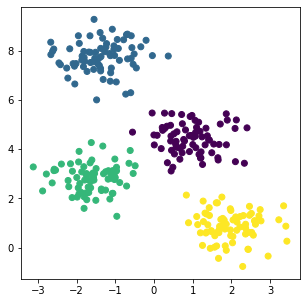

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0],X[:,1],c=kms["labels"].argmax(-1))
plt.show()

# compare to sklearn

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# harder problem?
X, y_true = make_blobs(n_samples=10000, n_features=100, centers=32,
                       cluster_std=1.0, random_state=0)
true_means = np.array([np.mean(X[y_true == i],0) for i in range(32)])
_dist(jnp.array(X),jnp.array(true_means)).min(-1).sum()

DeviceArray(996697.9, dtype=float32)

In [ ]:
%%time
kms = KMeans(32).fit(X)
print(kms.inertia_)

996697.6971604618
CPU times: user 1.65 s, sys: 824 ms, total: 2.47 s
Wall time: 1.29 s


In [ ]:
%%time
# first time is "slow" since it needs to compile
kms = kmeans_jit(jnp.array(X), jnp.ones(X.shape[0]), 32)
print(kms["inertia"])

996697.7
CPU times: user 2.13 s, sys: 23.4 ms, total: 2.16 s
Wall time: 2.17 s


In [ ]:
%%time
kms = kmeans_jit(jnp.array(X), jnp.ones(X.shape[0]), 32)
print(kms["inertia"])

996697.7
CPU times: user 32.6 ms, sys: 884 µs, total: 33.5 ms
Wall time: 32.8 ms


# Useless experiments
backprop through kmeans??

In [ ]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/laxy/main/laxy.py
import laxy

In [ ]:
def diff_kmeans(X, X_weight, n_clusters=8,
               em_steps=10, iters=1000, seed=0):
  '''kmeans implemented in jax'''

  # initialize mean params with _kmeans_plus_plus
  key = jax.random.PRNGKey(seed)
  params = {"means":_kmeans_plus_plus(key, X, X_weight, n_clusters)}
  inputs = {"X":X, "X_weight":X_weight}

  def model(params, inputs):
    def _E(means):
      # get labels
      dist = _dist(inputs["X"],means)
      soft_labels = jax.nn.softmax(-dist/inputs["X"].shape[1])
      hard_labels = jax.nn.one_hot(dist.argmin(-1), n_clusters)
      return jax.lax.stop_gradient(hard_labels - soft_labels) + soft_labels

    def _M(labels):
      # get means
      labels = labels * inputs["X_weight"][:,None]
      labels /= labels.sum(0) + 1e-8
      return labels.T @ inputs["X"]
    
    means = jax.lax.scan(lambda mu,_:(_M(_E(mu)),None), params["means"],
                         None, length=em_steps)[0]

    inertia = _dist(X,means).min(-1)
    return means, (inputs["X_weight"] * inertia).sum()

  opt = laxy.OPT(model, params, lr=1e-2)
  opt.fit(inputs, iters)
  means = opt.predict(inputs)
  inertia = opt.evaluate(inputs)
  return {"means":means,
          "inertia":inertia}

In [ ]:
kms = diff_kmeans(jnp.array(X), jnp.ones(X.shape[0]),
                 n_clusters=32, em_steps=0)

100 1178672.2
200 1031705.7
300 1003447.75
400 997981.3
500 996940.44
600 996744.0
700 996706.3
800 996698.94
900 996698.0
1000 996697.25


In [ ]:
kms = diff_kmeans(jnp.array(X), jnp.ones(X.shape[0]),
                 n_clusters=32, em_steps=10)

100 996697.75
200 996697.75
300 996697.75
400 996697.75
500 996697.75
600 996697.75
700 996697.75
800 996697.75
900 996697.75
1000 996697.75
